In [2]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5

from datetime import datetime
from prophet import Prophet
import warnings
import matplotlib.pyplot as plt



c:\Users\rodrigo\Desktop\NLP\venvs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# prediccion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
# FXPRO
server="FxPro-MT5"
login = "5843847"
password="bYsJsFu9"
if  mt5.initialize(server=server, login=login, password=password)==False:
    mt5.initialize(server=server, login=login, password=password)
    print("Se conecto")

def preprocessing_mt5(symbol, n, timeframe=mt5.TIMEFRAME_H1):

    if mt5.initialize() == False:
        mt5.initialize()
        
    # Current date extract
    utc_from = datetime.now()
    # Import the data into a tuple
    rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n)
    # Tuple to dataframe
    rates_frame = pd.DataFrame(rates)
    # Convert time in seconds into the datetime format
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    # Convert the column "time" in the right format
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], format='%Y-%m-%d')
    # Set column time as the index of the dataframe
    rates_frame = rates_frame.set_index('time')

    # Delete the two last columns
    rates_frame = rates_frame.iloc[:,:-2]
    # Rename
    rates_frame.columns = ["open", "high", "low", "close", "volume"]
    
    # Desconectar del servidor de MetaTrader 5
    mt5.shutdown()
    return rates_frame

Se conecto


In [19]:
preprocessing_mt5("BITCOIN",1304)#EURUSD

,open,high,low,close,volume
time,,,,,
2023-09-18 06:00:00,26651.34,26675.83,26572.36,26646.34,724
2023-09-18 07:00:00,26651.34,26667.33,26554.86,26613.84,666
2023-09-18 08:00:00,26616.84,26672.83,26600.35,26636.84,498
2023-09-18 09:00:00,26636.34,26689.83,26613.35,26613.35,583
2023-09-18 10:00:00,26614.34,26800.30,26614.34,26700.32,931
...,...,...,...,...,...
2023-11-11 19:00:00,37141.09,37172.22,37042.00,37107.24,12158
2023-11-11 20:00:00,37107.24,37138.70,37081.00,37118.24,11243
2023-11-11 21:00:00,37118.24,37172.18,37084.18,37136.58,10807


# Estrategias 

### a) SMA (medias moviles)

In [7]:
def SMA_strategy(input,mt5_live=True,n=7000):

    if mt5_live:
        df = preprocessing_mt5(input, n=n)

    # Create Resistance using a rolling max
    df["SMA fast"] = df["close"].rolling(30).mean()

    # Create Support using a rolling min
    df["SMA slow"] = df["close"].rolling(60).mean()

    df["position"] = np.nan

    # Create the condition
    df.loc[(df["SMA fast"] < df["SMA slow"]) , "position"] = 1
    df.loc[(df["SMA fast"] > df["SMA slow"]) , "position"] = -1

    df["pct"] = df["close"].pct_change(1)

    # Compute the return of the strategy

    df["return"] = df["pct"] * (df["position"].shift(1))
    
    return df#df["return"]

(7000, 10)


<Axes: >

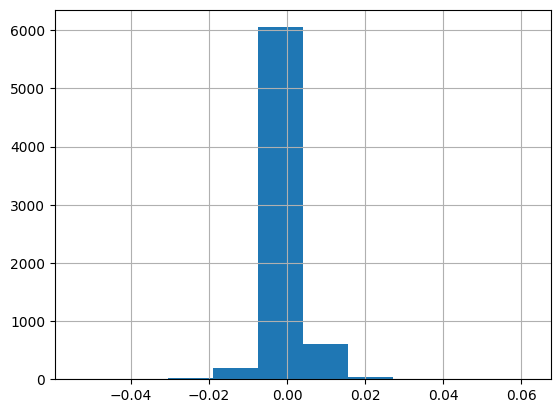

In [20]:
resul=SMA_strategy("BITCOIN", mt5_live=True)
print(resul.shape)
resul['return'].hist()

### b) Resistencia SMA y RSI

In [59]:
import ta

def support_resistance(input,n=1000,duration=5,spread=0, mt5_live=True):

    if mt5_live:
        df = preprocessing_mt5(input,n=n)
    
    # Support and resistance building
    df["support"] = np.nan
    df["resistance"] = np.nan

    df.loc[(df["low"].shift(5) > df["low"].shift(4)) &
            (df["low"].shift(4) > df["low"].shift(3)) &
            (df["low"].shift(3) > df["low"].shift(2)) &
            (df["low"].shift(2) > df["low"].shift(1)) &
            (df["low"].shift(1) > df["low"].shift(0)), "support"] = df["low"]


    df.loc[(df["high"].shift(5) < df["high"].shift(4)) &
    (df["high"].shift(4) < df["high"].shift(3)) &
    (df["high"].shift(3) < df["high"].shift(2)) &
    (df["high"].shift(2) < df["high"].shift(1)) &
    (df["high"].shift(1) < df["high"].shift(0)), "resistance"] = df["high"]

    # Create Simple moving average 30 days
    df["SMA fast"] = df["close"].rolling(30).mean()

    # Create Simple moving average 60 days
    df["SMA slow"] = df["close"].rolling(60).mean()

    df["rsi"] = ta.momentum.RSIIndicator(df["close"], window=10).rsi()

    # RSI yersteday
    df["rsi yersteday"] = df["rsi"].shift(1)

    # Create the signal
    df["signal"] = 0

    df["smooth resistance"] = df["resistance"].fillna(method="ffill")
    df["smooth support"] = df["support"].fillna(method="ffill")

    
    condition_1_buy = (df["close"].shift(1) < df["smooth resistance"].shift(1)) & \
                        (df["smooth resistance"]*(1+0.5/100) < df["close"])
    condition_2_buy = df["SMA fast"] > df["SMA slow"]

    condition_3_buy = df["rsi"] < df["rsi yersteday"]

    condition_1_sell = (df["close"].shift(1) > df["smooth support"].shift(1)) & \
                        (df["smooth support"]*(1+0.5/100) > df["close"])
    condition_2_sell = df["SMA fast"] < df["SMA slow"]

    condition_3_sell = df["rsi"] > df["rsi yersteday"]

    df.loc[condition_1_buy & condition_2_buy & condition_3_buy, "signal"] = 1
    df.loc[condition_1_sell & condition_2_sell & condition_3_sell, "signal"] = -1


    # Calculamos las ganancias
    df["pct"] = df["close"].pct_change(1)

    df["return"] = np.array([df["pct"].shift(i) for i in range(duration)]).sum(axis=0) * (df["signal"].shift(duration))
    df.loc[df["return"]==-1, "return"] = df["return"]-spread
    df.loc[df["return"]==1, "return"] = df["return"]-spread


    return df#["return"]

(1000, 16)


C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\1425703152.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth resistance"] = df["resistance"].fillna(method="ffill")
C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\1425703152.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth support"] = df["support"].fillna(method="ffill")


<Axes: >

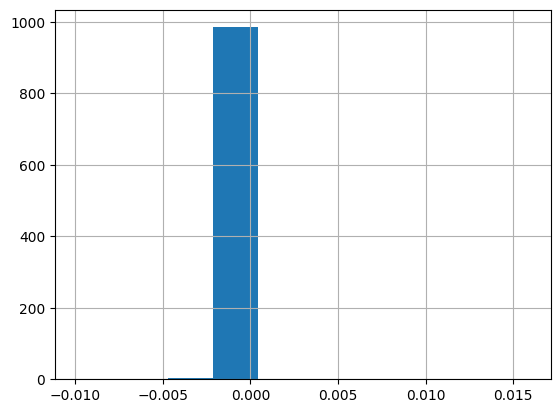

In [40]:
resul=support_resistance("BITCOIN")
print(resul.shape)
resul['return'].hist()

In [9]:
def drawdown_function(serie):

    # Calculamos la suma de los rendimientos
    cum = serie.dropna().cumsum() + 1
    
    # Calculamos el máximo de la suma en el período (máximo acumulado) # (1,3,5,3,1) --> (1,3,5,5,5)
    running_max = np.maximum.accumulate(cum)
    
    # Calculamos el drawdown
    drawdown = cum/running_max - 1
    return drawdown

In [17]:
preprocessing_mt5('#US500_Z23', n=7000)

,open,high,low,close,volume
time,,,,,
2017-10-09 00:00:00,2543.00,2550.25,2539.25,2543.00,3325
2017-10-10 00:00:00,2542.75,2553.25,2542.75,2548.75,4629
2017-10-11 00:00:00,2548.50,2553.25,2544.25,2552.25,3419
2017-10-12 00:00:00,2551.75,2553.00,2546.00,2548.50,2480
2017-10-13 00:00:00,2547.75,2555.50,2546.75,2552.75,3166
...,...,...,...,...,...
2023-11-10 19:00:00,4391.25,4413.75,4390.50,4411.50,1669
2023-11-10 20:00:00,4411.25,4421.25,4405.50,4418.75,1695
2023-11-10 21:00:00,4419.00,4423.00,4417.75,4420.25,1322


In [32]:
import matplotlib.pyplot as plt

def BackTest(serie, annualiazed_scalar=252):
    # Importar el benchmark
    sp500 = preprocessing_mt5('#US500_Z23', n=7000)['close'].pct_change(1)# cambio porcentual del actual valor con el de 1 atras

    # Cambiar el nombre
    sp500.name = "SP500"

    # Concatenar los retornos y el sp500
    val = pd.concat((serie,sp500), axis=1).dropna()
    # Calcular el drawdown
    drawdown = drawdown_function(serie)*100

    # Calcular el max drawdown
    max_drawdown = -np.min(drawdown)

    # Put a subplots
    fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))

    # Put a Suptitle
    fig.suptitle("Backtesting", size=20)

    # Returns cumsum chart
    cum.plot(serie.cumsum()*100, color="#39B3C7")

    # SP500 cumsum chart
    cum.plot(val["SP500"].cumsum()*100, color="#B85A0F")

    # Put a legend
    cum.legend(["La prueba", "SP500"])

    # Set individual title
    cum.set_title("Cumulative Return", size=13)

    cum.set_ylabel("Cumulative Return %", size=11)

    # Put the drawdown
    dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

    # Set individual title
    dra.set_title("Drawdown de lo que pruebo en SMA_strategy", size=13)

    dra.set_ylabel("drawdown en %", size=11)

    # Plot the graph
    plt.show()

    # Calcular el índice sortino
    sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

    # Calcular el índice  beta
    beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

    # Calcular el índice  alpha
    alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

    # Imprimir los estadísticos
    print(f"Sortino: {np.round(sortino,3)}")
    print(f"Beta: {np.round(beta,3)}")
    print(f"Alpha: {np.round(alpha*100,3)} %")
    print(f"MaxDrawdown: {np.round(max_drawdown,3)} %")

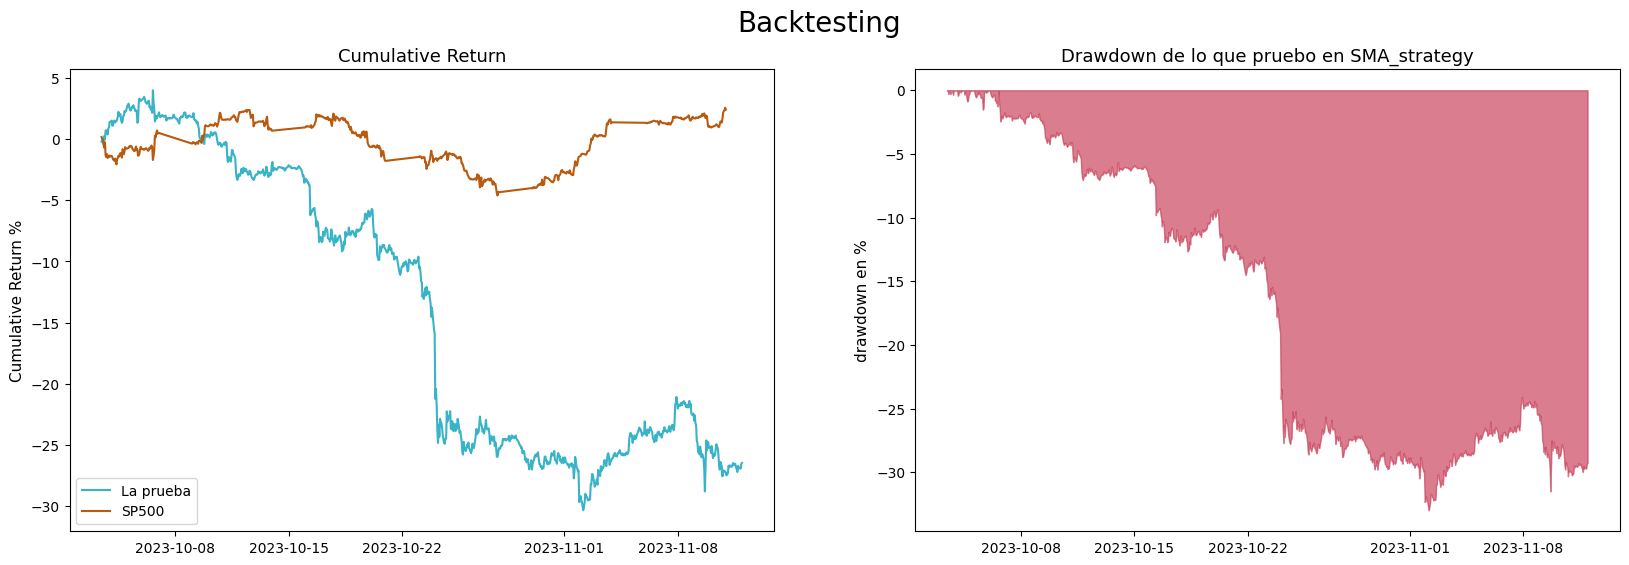

Sortino: -1.139
Beta: -0.324
Alpha: -9.389 %
MaxDrawdown: 32.996 %


In [33]:
strategy=SMA_strategy("BITCOIN",n=1000, mt5_live=True) # para año mes dia (con api) ## cartera PYPL, PFE (farmaceutica)
dfc = strategy['return'].loc["2020":]-0.00001 # coste de transaccion .00001

BackTest(dfc, 252)

">1" riesgo menor que rendimiento: <br> "<1" menor b=> menor riesgo: <br>  ">0" rendimiento superior al mercado

<Axes: xlabel='time'>

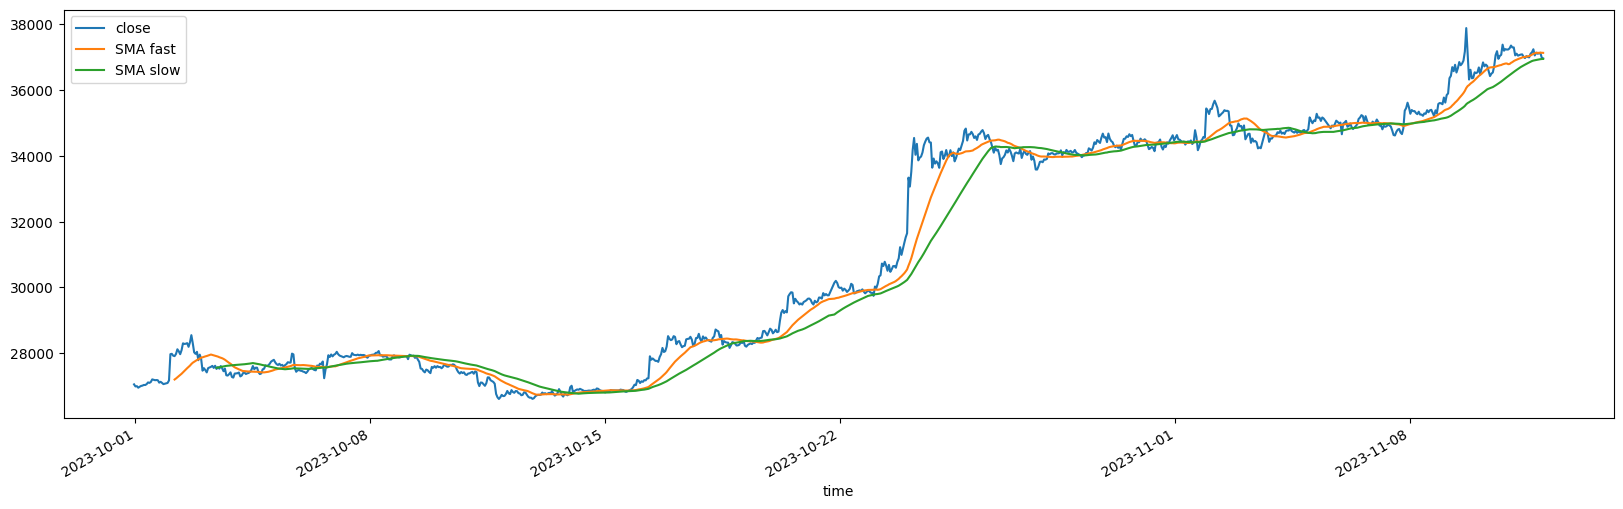

In [34]:
strategy[["close", "SMA fast", "SMA slow"]].loc["2020":].plot(figsize=(20,6))

### Diversificar cartera(estrategia support_resistance)

C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth resistance"] = df["resistance"].fillna(method="ffill")
C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth support"] = df["support"].fillna(method="ffill")
C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth resistance"] = df["resistance"].fillna(method="ffill")
C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() ins

<Axes: xlabel='time'>

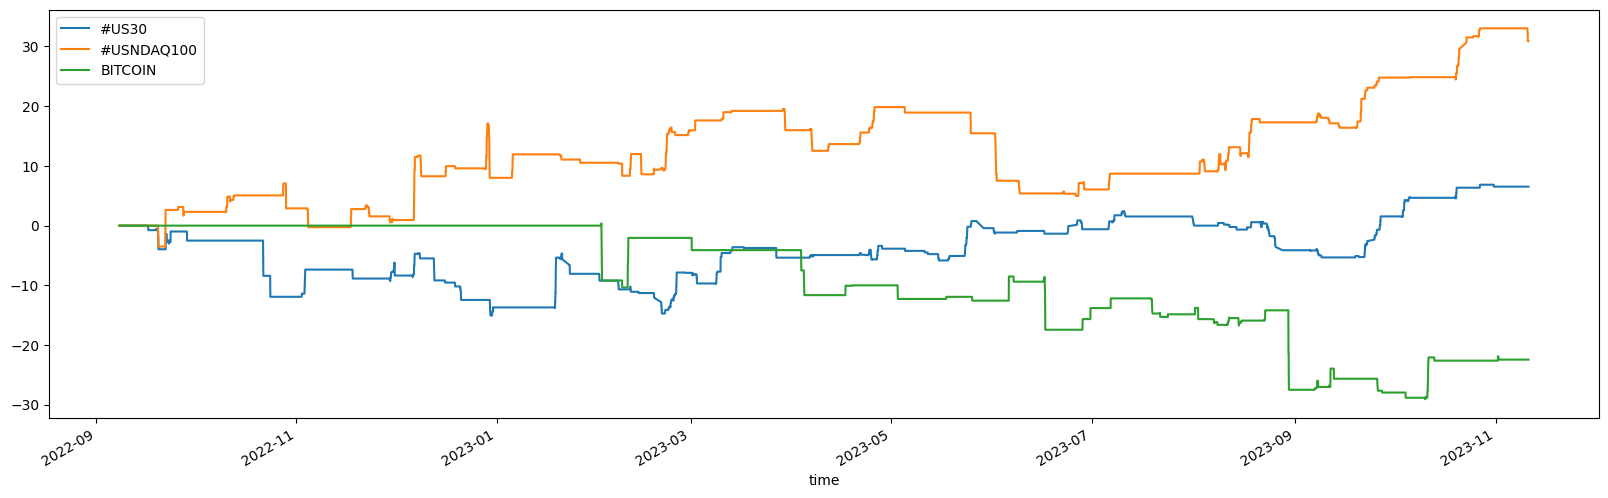

In [76]:
# Lista de assets
listnames = ["#US30","#USNDAQ100",'BITCOIN']
returns = pd.DataFrame()

# Calcular la rentabilidad de cada estrategia
for name in listnames:

    returns[name] = support_resistance(name,mt5_live=True,n=7000, duration=10, spread=0.01)['return']

# Representar los resultados
(returns.fillna(value=0).cumsum()*100).plot(figsize=(20,6))

In [77]:
returns["portfolio"] = returns.sum(axis=1)/returns.shape[1]

# Dataframe vacío
values = pd.DataFrame(index=["RETURN", "DRAWDOWN", "RETURN DRAWDOWN RATIO"])

# Calculamos retorno/drawdown
for col in returns.columns:
    ret = (returns[col].dropna().cumsum().iloc[-1])
    dd = -np.min(drawdown_function(returns[col].dropna()))
    ret_dd = ret/dd
    
    values[col] = ret,dd,ret_dd

values.transpose().sort_values(by="RETURN DRAWDOWN RATIO", ascending=False)

,RETURN,DRAWDOWN,RETURN DRAWDOWN RATIO
#USNDAQ100,0.308884,0.124174,2.487518
portfolio,0.049938,0.085688,0.582794
#US30,0.065296,0.150473,0.433936
BITCOIN,-0.224364,0.293308,-0.764944


RETURN DRAWDOWN RATIO=2.48 me dice que es mas rentable que riesgoso, todo lo contrario con Bitoin 

### Drawdown

C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth resistance"] = df["resistance"].fillna(method="ffill")
C:\Users\rodrigo\AppData\Local\Temp\ipykernel_7220\3754047584.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["smooth support"] = df["support"].fillna(method="ffill")


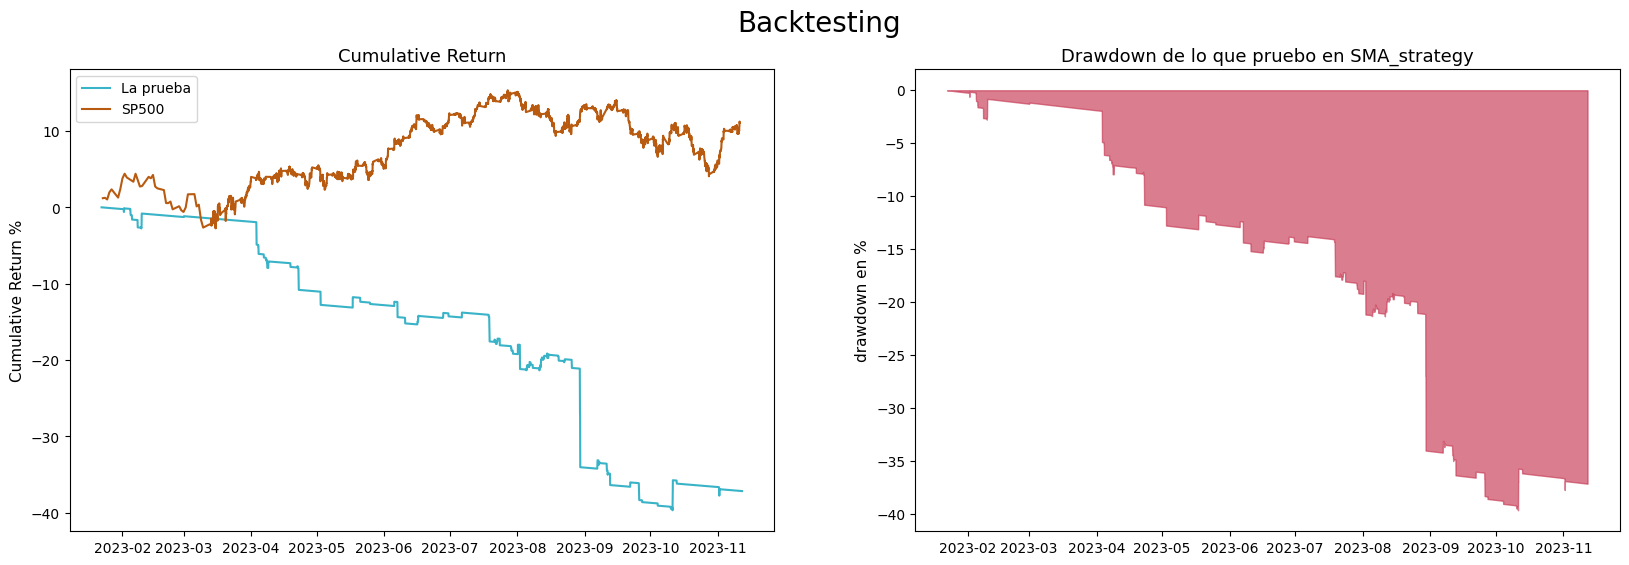

Sortino: -0.641
Beta: -0.024
Alpha: -1.371 %
MaxDrawdown: 39.679 %


In [78]:
strategy=support_resistance("BITCOIN",n=7000, mt5_live=True) # para año mes dia (con api) ## cartera PYPL, PFE (farmaceutica)
dfc = strategy['return'].loc["2020":]-0.00001 # coste de transaccion .00001

BackTest(dfc, 252)

">1" Sortino riesgo menor que rendimiento: <br> "<1" Beta menor b=> menor riesgo: <br>  ">0" Alpha rendimiento superior al mercado

<Axes: xlabel='time'>

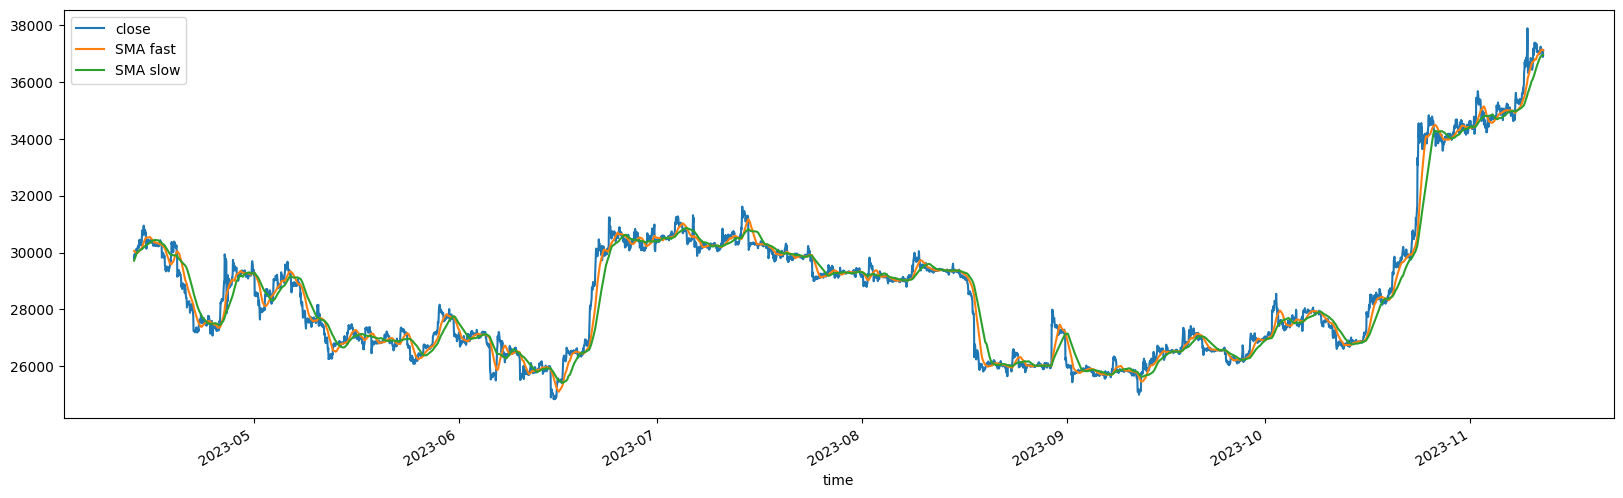

In [79]:
strategy[["close", "SMA fast", "SMA slow"]].loc["2023-04-12 22:00:00":].plot(figsize=(20,6))

In [80]:
strategy

,open,high,low,close,volume,support,resistance,SMA fast,SMA slow,rsi,rsi yersteday,signal,smooth resistance,smooth support,pct,return
time,,,,,,,,,,,,,,,,
2023-01-22 05:00:00,22679.32,22746.06,22647.00,22731.77,12234,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2023-01-22 06:00:00,22731.77,22835.68,22692.73,22817.06,11725,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.003752,NaN
2023-01-22 07:00:00,22817.26,22864.42,22811.90,22853.13,11717,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.001581,NaN
2023-01-22 08:00:00,22853.33,22936.61,22840.66,22897.99,11231,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.001963,NaN
2023-01-22 09:00:00,22897.99,22932.01,22856.22,22869.65,11524,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,-0.001238,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-11 21:00:00,37118.24,37172.18,37084.18,37136.58,10807,NaN,NaN,37139.152000,36941.359333,53.445483,52.068619,0,37264.18,34297.92,0.000494,-0.0
2023-11-11 22:00:00,37136.58,37146.08,36972.77,36989.31,11584,NaN,NaN,37137.479000,36946.750667,42.542072,53.445483,0,37264.18,34297.92,-0.003966,-0.0
2023-11-11 23:00:00,36989.31,37063.14,36907.22,36965.08,11814,NaN,NaN,37133.840667,36948.605667,41.012519,42.542072,0,37264.18,34297.92,-0.000655,-0.0


# Series temporales

In [3]:
bit=preprocessing_mt5("BITCOIN",1304)#EURUSD
bit.tail(3)

,open,high,low,close,volume
time,,,,,
2023-11-12 16:00:00,37068.60,37176.85,37066.73,37142.18,11262
2023-11-12 17:00:00,37142.18,37216.19,37080.00,37160.51,11524
2023-11-12 18:00:00,37159.57,37186.20,37112.43,37115.68,11049


In [5]:
bit=bit.reset_index()
bit= bit.rename(columns={'time':'ds','close':'y'})
bit.tail(3)

,ds,open,high,low,y,volume
1301,2023-11-12 11:00:00,37093.95,37099.32,37021.84,37058.58,10961
1302,2023-11-12 12:00:00,37058.58,37118.22,37028.26,37084.23,10995
1303,2023-11-12 13:00:00,37084.23,37106.83,37049.04,37053.82,10888


In [6]:
# 1b) Instanciamos y entrenamos
model=Prophet(
    yearly_seasonality=True, # estacionalidad anual
    weekly_seasonality=True, # estacionalidad semanal
    daily_seasonality=False, # no se considera estacionalidad diaria
    holidays_prior_scale=10, # prioridad para efectos festivos
    uncertainty_samples=50,  # 50 predicciones diferentes para cada punto en el
    mcmc_samples=50,         # controla cuantas muestras se genera en  la tecnica
    interval_width=0.6       # controla el ancho del intervalo de confianza
)

model.add_country_holidays(country_name='US') # agregar festivos de EEUU

model.fit(bit) # ajustar el modelo a los datos historicos

10:42:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |██████████| 00:01 Iteration:  1 / 50 [  2%]  (Warmup)
chain 1 |██████████| 00:03 Sampling completed                   
chain 2 |██████████| 00:03 Sampling completed

chain 3 |██████████| 00:03 Sampling completed


chain 4 |██████████| 00:03 Sampling completed


10:42:31 - cmdstanpy - INFO - CmdStan done processing.
10:42:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

Guardar modelo

In [48]:
import joblib
# Guarda el vectorizador
joblib.dump(model, 'serie_temporal.pkl')

['serie_temporal.pkl']

In [49]:
# 1c) predecimos etiqueta de uba salida
future_date = pd.to_datetime("2023-11-12 04:00:00")
future = pd.DataFrame({'ds':[future_date]})
# predecimos
forecast = model.predict(future)

# obterner componentes de pronostico
trend_component=forecast['trend'].iloc[0]
weekly_seasonality_component= forecast['weekly'].iloc[0]
yearly_seasonality_component=forecast['yearly'].iloc[0]
holiday_effect=forecast['holidays'].iloc[0]

print("tendencia: ",trend_component)
print("estacionalidad semanal: ", weekly_seasonality_component)
print("estacionalidad anual: ",yearly_seasonality_component)
print("efecto festivos: ",holiday_effect)

# obtener precio para una fecha dada
predicted_price=forecast['yhat'].iloc[0]
print("precio predicho para: ",future_date,"  es de: ",predicted_price)

tendencia:  43763.70120506839
estacionalidad semanal:  -77.01557194328122
estacionalidad anual:  -6703.109800172922
efecto festivos:  0.0
precio predicho para:  2023-11-12 04:00:00   es de:  36983.57583295219


In [50]:
bit.tail(3)

,ds,open,high,low,y,volume
1301,2023-11-12 02:00:00,37120.57,37168.21,36728.26,36895.89,11984
1302,2023-11-12 03:00:00,36895.89,36999.67,36831.91,36951.57,13254
1303,2023-11-12 04:00:00,36951.57,36955.82,36846.77,36898.62,12658


In [54]:
# 1c) predecimos etiqueta para muchas salidas
future = model.make_future_dataframe(periods=4, freq='H') #32 semanas tiene un año
forecast = model.predict(future)

forecast[['ds','yhat']]#.tail(7)

,ds,yhat
0,2023-09-18 11:00:00,27065.804425
1,2023-09-18 12:00:00,27067.790155
2,2023-09-18 13:00:00,27070.650862
3,2023-09-18 14:00:00,27074.280137
4,2023-09-18 15:00:00,27078.566488
...,...,...
1303,2023-11-12 04:00:00,36983.575833
1304,2023-11-12 05:00:00,37005.416585
1305,2023-11-12 06:00:00,37026.988972
1306,2023-11-12 07:00:00,37048.389574


c:\Users\rodrigo\Desktop\NLP\venvs\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\rodrigo\Desktop\NLP\venvs\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


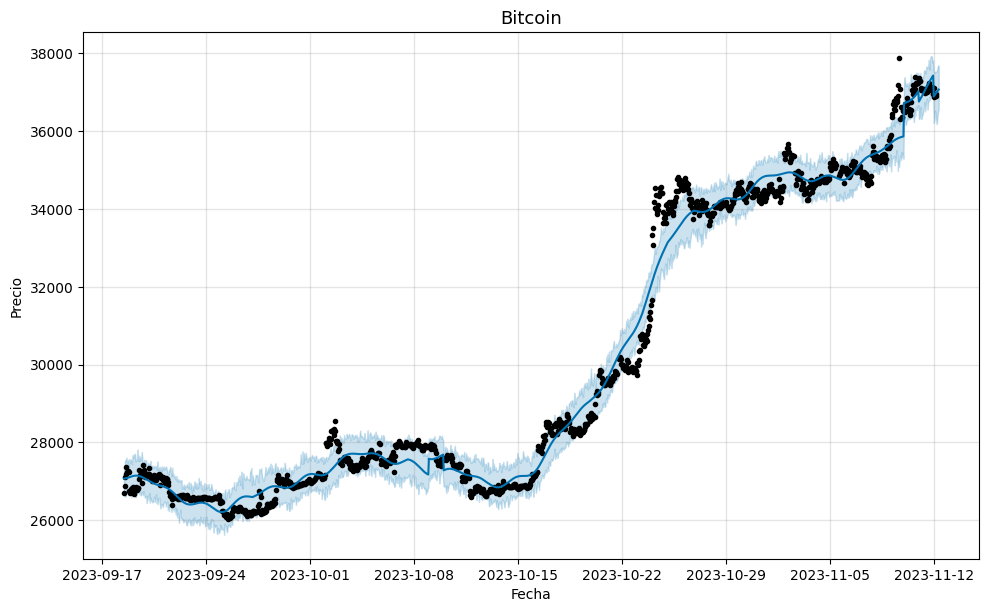

In [73]:
# 1d grafica precios predichos en un año
model.plot(forecast,xlabel='Fecha',ylabel='Precio')
plt.title('Bitcoin',fontsize=13)
plt.show()

In [65]:
# 4a)  errores
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

df_cv=cross_validation(model, horizon="72 hours", initial="220 hours")#horizon="5 day")

#plot_cross_validation_metric(df_cv,metric='rmse')

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/29 [00:00<?, ?it/s]

10:20:39 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:20:39 - cmdstanpy - INFO - CmdStan done processing.
10:20:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
10:20:39 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 ha

10:20:39 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:20:39 - cmdstanpy - INFO - CmdStan done processing.
10:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

10:20:40 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:20:40 - cmdstanpy - INFO - CmdStan done processing.
10:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, col

10:20:40 - cmdstanpy - INFO - CmdStan start processing









chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 



chain 4 |██████████| 00:00 Sampling completed


10:20:40 - cmdstanpy - INFO - CmdStan done processing.
10:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

10:20:41 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:20:41 - cmdstanpy - INFO - CmdStan done processing.
10:20:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, col

10:20:41 - cmdstanpy - INFO - CmdStan start processing














chain 1 |██████████| 00:00 Sampling completed

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   



chain 4 |██████████| 00:00 Sampling completed


10:20:42 - cmdstanpy - INFO - CmdStan done processing.
10:20:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Excep

10:20:42 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                 


chain 3 |██████████| 00:00 Sampling completed



chain 4 |██████████| 00:00 Sampling completed


10:20:43 - cmdstanpy - INFO - CmdStan done processing.
10:20:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Excep

10:20:43 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed                   

chain 2 |██████████| 00:01 Sampling completed


chain 3 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                 


10:20:44 - cmdstanpy - INFO - CmdStan done processing.
10:20:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, col

10:20:45 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:20:45 - cmdstanpy - INFO - CmdStan done processing.
10:20:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Excep

10:20:45 - cmdstanpy - INFO - CmdStan start processing














chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                 
chain 3 |██████████| 00:01 Sampling completed                   



chain 4 |██████████| 00:01 Sampling completed


10:20:47 - cmdstanpy - INFO - CmdStan done processing.
10:20:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf

10:20:47 - cmdstanpy - INFO - CmdStan start processing















chain 1 |██████████| 00:02 Sampling completed
chain 2 |██████████| 00:02 Sampling completed                   
chain 3 |██████████| 00:02 Sampling completed                   
chain 4 |██████████| 00:02 Sampling completed                 


10:20:49 - cmdstanpy - INFO - CmdStan done processing.
10:20:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal

10:20:50 - cmdstanpy - INFO - CmdStan start processing














chain 1 |██████████| 00:02 Sampling completed

chain 2 |██████████| 00:02 Sampling completed
chain 3 |██████████| 00:02 Sampling completed                   



chain 4 |██████████| 00:02 Sampling completed


10:20:52 - cmdstanpy - INFO - CmdStan done processing.
10:20:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf

10:20:52 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed                   

chain 2 |██████████| 00:01 Sampling completed


chain 3 |██████████| 00:01 Sampling completed



chain 4 |██████████| 00:01 Sampling completed


10:20:53 - cmdstanpy - INFO - CmdStan done processing.
10:20:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf

10:20:54 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed

chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                 


10:20:54 - cmdstanpy - INFO - CmdStan done processing.
10:20:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:20:54 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:02 Sampling completed                   

chain 2 |██████████| 00:02 Sampling completed


chain 3 |██████████| 00:02 Sampling completed



chain 4 |██████████| 00:02 Sampling completed


10:20:57 - cmdstanpy - INFO - CmdStan done processing.
10:20:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, 

10:20:57 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 

chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed



chain 4 |██████████| 00:00 Sampling completed


10:20:58 - cmdstanpy - INFO - CmdStan done processing.
10:20:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:20:58 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed

chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                 


10:20:59 - cmdstanpy - INFO - CmdStan done processing.
10:20:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:20:59 - cmdstanpy - INFO - CmdStan start processing















chain 1 |██████████| 00:02 Sampling completed
chain 2 |██████████| 00:02 Sampling completed                   
chain 3 |██████████| 00:02 Sampling completed                   



chain 4 |██████████| 00:02 Sampling completed


10:21:02 - cmdstanpy - INFO - CmdStan done processing.
10:21:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:02 - cmdstanpy - INFO - CmdStan start processing















chain 1 |██████████| 00:02 Sampling completed

chain 2 |██████████| 00:02 Sampling completed


chain 3 |██████████| 00:02 Sampling completed
chain 4 |██████████| 00:02 Sampling completed                   


10:21:04 - cmdstanpy - INFO - CmdStan done processing.
10:21:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:05 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                 


chain 3 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                 


10:21:06 - cmdstanpy - INFO - CmdStan done processing.
10:21:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:06 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed                   
chain 2 |██████████| 00:01 Sampling completed                 


chain 3 |██████████| 00:01 Sampling completed



chain 4 |██████████| 00:01 Sampling completed


10:21:07 - cmdstanpy - INFO - CmdStan done processing.
10:21:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:08 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 

chain 2 |██████████| 00:00 Sampling completed


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                 


10:21:08 - cmdstanpy - INFO - CmdStan done processing.
10:21:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:09 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 



chain 4 |██████████| 00:00 Sampling completed


10:21:09 - cmdstanpy - INFO - CmdStan done processing.
10:21:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:09 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed                   

chain 2 |██████████| 00:01 Sampling completed


chain 3 |██████████| 00:01 Sampling completed



chain 4 |██████████| 00:01 Sampling completed


10:21:11 - cmdstanpy - INFO - CmdStan done processing.
10:21:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:11 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed                 


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                 


10:21:11 - cmdstanpy - INFO - CmdStan done processing.
10:21:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:12 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                 



chain 4 |██████████| 00:00 Sampling completed


10:21:13 - cmdstanpy - INFO - CmdStan done processing.
10:21:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to 

10:21:13 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


10:21:13 - cmdstanpy - INFO - CmdStan done processing.
10:21:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:14 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                 
chain 3 |██████████| 00:00 Sampling completed                 



chain 4 |██████████| 00:00 Sampling completed


10:21:14 - cmdstanpy - INFO - CmdStan done processing.
10:21:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

10:21:15 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:01 Sampling completed
chain 2 |██████████| 00:01 Sampling completed                 


chain 3 |██████████| 00:01 Sampling completed
chain 4 |██████████| 00:01 Sampling completed                 


10:21:16 - cmdstanpy - INFO - CmdStan done processing.
10:21:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to 

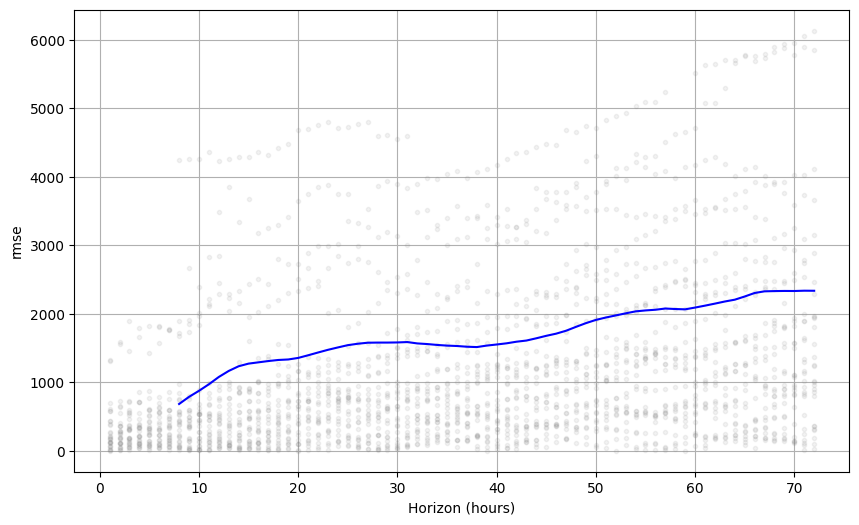

In [66]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [67]:
df_p = performance_metrics(df_cv)
print('El RMSE es:', df_p.rmse.mean())

El RMSE es: 1694.9250165652932


# Machine Learning

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
bit=preprocessing_mt5("BITCOIN",1304)#EURUSD
bit.tail(3)

,open,high,low,close,volume
time,,,,,
2023-11-12 22:00:00,37088.77,37149.43,37068.40,37124.72,10881
2023-11-12 23:00:00,37124.72,37194.76,37124.72,37166.76,11097
2023-11-13 00:00:00,37166.76,37167.52,37166.76,37166.76,54


In [8]:
bit['fecha_numeros']=(bit.index- pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
bit.head(3)

,open,high,low,close,volume,fecha_numeros
time,,,,,,
2023-09-19 07:00:00,26804.30,26847.29,26794.80,26845.29,493,1695106800
2023-09-19 08:00:00,26845.29,26848.29,26782.30,26784.30,525,1695110400
2023-09-19 09:00:00,26783.30,26817.79,26745.31,26817.29,554,1695114000


In [9]:
# Desconvertir la columna 'time_numerico' a formato datetime
bit['time_desconvertido'] = pd.to_datetime(bit['fecha_numeros'], unit='s')
bit.head(3)

,open,high,low,close,volume,fecha_numeros,time_desconvertido
time,,,,,,,
2023-09-19 07:00:00,26804.30,26847.29,26794.80,26845.29,493,1695106800,2023-09-19 07:00:00
2023-09-19 08:00:00,26845.29,26848.29,26782.30,26784.30,525,1695110400,2023-09-19 08:00:00
2023-09-19 09:00:00,26783.30,26817.79,26745.31,26817.29,554,1695114000,2023-09-19 09:00:00


In [10]:
y= bit['close']
x= bit['fecha_numeros']#bit.drop(['close',],axis=1)
X=x.values.reshape(-1,1)

In [25]:
# Separamos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Modelo 1 Regresion Lineal

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Crear un rl de regresión lineal
rl = LinearRegression()

# Crear y ajustar un rl de Regresión Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

# Predecir valores en el conjunto de prueba
#y_pred = rl.predict(X_test)
y_train_pred = rl.predict(X_train)
y_test_pred = rl.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE) en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
print('Error Cuadrático Medio (mse_test) en el conjunto de prueba:', mse_test** 0.5)
print('Error Cuadrático Medio (mse_train) en el conjunto de prueba:', mse_train** 0.5)

Error Cuadrático Medio (mse_test) en el conjunto de prueba: 1495.3673955413112
Error Cuadrático Medio (mse_train) en el conjunto de prueba: 1510.6472944565874


#### Modelo 2 Regresion Bayesiana Ridge

In [15]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Crear un rbr de regresión Bayesian Ridge
rbr = BayesianRidge()
rbr.fit(X_train, y_train)

# Predecir valores en el conjunto de prueba
y_train_pred = rbr.predict(X_train)
y_test_pred = rbr.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE) en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print('Error Cuadrático Medio (mse_test) en el conjunto de prueba:', mse_test**0.5)
print('Error Cuadrático Medio (mse_train) en el conjunto de prueba:', mse_train**0.5)

Error Cuadrático Medio (mse_test) en el conjunto de prueba: 1495.3907396335396
Error Cuadrático Medio (mse_train) en el conjunto de prueba: 1510.6473718606687


#### Modelo 3 K-Nearest Neighbors(K-NN)

In [24]:
from sklearn.neighbors import KNeighborsRegressor

# Crear un knn de regresión K-NN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predecir valores en el conjunto de prueba
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE) en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print('Error Cuadrático Medio (mse_test) en el conjunto de prueba:', mse_test**0.5)
print('Error Cuadrático Medio (mse_train) en el conjunto de prueba:', mse_train**0.5)

Error Cuadrático Medio (mse_test) en el conjunto de prueba: 134.82709890648962
Error Cuadrático Medio (mse_train) en el conjunto de prueba: 90.84511306823096


#### Metamodelo

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor

Staking

In [18]:
# Se define la lista de estimadores con los 3 modelos generados
estimator_list = [
    ('rl',rl),
    ('svr',rbr),
    ('mpl',knn)]

# Se genera el modelo apilado (stacking)
# Se estima con los 3 modelos generados
# El estimador de la predicción final será una regresión logística (metamodelo). Se entrena el metamodelo
stack_model =  StackingRegressor(estimators=estimator_list, final_estimator=DecisionTreeRegressor(max_depth=5))

Voting

In [27]:
param_grid = {
    'rl__fit_intercept': [True, False],             # Parámetros para LinearRegression
    'svr__alpha_1': [1e-6, 1e-5, 1e-4],           # Parámetros para BayesianRidge
    'mpl__n_neighbors': [3, 5, 7],                 # Parámetros para KNeighborsRegressor
    #'rh__alpha': [0.0001, 0.001, 0.01],            # Parámetros para HuberRegressor
    'final_estimator__max_depth': [3, 5, 7]        # Parámetros para DecisionTreeRegressor (estimador final)
}

estimator_list_vot=[('rl',rl),
                    ('svr',rbr),
                    ('mpl',knn)]

Crear Pipeline

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

# Crear pipeline
pipeline_stack = Pipeline(steps=[ #('pca',PCA(n_components=1)),
                            ('scl',StandardScaler()),
                            ('grid',GridSearchCV(stack_model, param_grid=param_grid, cv=5)) ])#("stacking", stack)

pipeline_voting = Pipeline(steps=[ #('pca',PCA(n_components=1)),
                            ('scl',StandardScaler()),
                            ('grid',VotingRegressor(estimators=estimator_list_vot) )])

In [29]:
# Los guardamos en una lista
pipelines = [pipeline_stack, pipeline_voting]
# Hacemos un diccionario para fines organizativos
pipe_dict = {0: 'stack', 1: 'voting'}

# Entrenamos
for pipe in pipelines:
	pipe.fit(X_train, y_train)

# Identificamos el mejor modelo para el set de testeo

best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))
	if val.score(X_test, y_test) > best_acc:
		best_acc = val.score(X_test, y_test)
		best_pipe = val
		best_clf = idx
print('\nModelo con el mejor accuracy: %s' % pipe_dict[best_clf],'%.3f', val.score(X_test, y_test))

stack pipeline accuracy en test: 0.999
voting pipeline accuracy en test: 0.931

Modelo con el mejor accuracy: stack %.3f 0.9310358706236752


Gruardar modelo

In [37]:
import joblib
joblib.dump(best_pipe,'model_best_pipeline.plk',compress=2)

['model_best_pipeline.plk']

fecha en numero

In [30]:
bit.index

DatetimeIndex(['2023-09-19 07:00:00', '2023-09-19 08:00:00',
               '2023-09-19 09:00:00', '2023-09-19 10:00:00',
               '2023-09-19 11:00:00', '2023-09-19 12:00:00',
               '2023-09-19 13:00:00', '2023-09-19 14:00:00',
               '2023-09-19 15:00:00', '2023-09-19 16:00:00',
               ...
               '2023-11-12 15:00:00', '2023-11-12 16:00:00',
               '2023-11-12 17:00:00', '2023-11-12 18:00:00',
               '2023-11-12 19:00:00', '2023-11-12 20:00:00',
               '2023-11-12 21:00:00', '2023-11-12 22:00:00',
               '2023-11-12 23:00:00', '2023-11-13 00:00:00'],
              dtype='datetime64[ns]', name='time', length=1304, freq=None)

In [35]:
fecha_numeros=(pd.to_datetime('2027-09-19 07:00:00') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


In [36]:
input_data = {
        #"open": [openai],
        #"high": [high],
        #"low": [low],
        #"volume": [volume],  # Agregar el nombre del nuevo juego
        "fecha_numeros":[fecha_numeros]
}
input_df = pd.DataFrame(input_data)

# Convertir el diccionario en una matriz bidimensional
input_array = np.array(list(input_data.values())).reshape(1, -1)

# Luego, puedes usar input_array para hacer la predicción
predicted_price = best_pipe.predict(input_array)
predicted_price[0]

37116.708